In [1]:
import pandas as pd
import networkx as nx
import json
from collections import defaultdict
import re

In [2]:
df = pd.read_csv('data_scopus.csv')
df.head()

,Title,Year,EID,Abstract,Publisher,Conference name,Conference date,Authors,Author(s) ID,Authors with affiliations,Source title,Abbreviated Source Title,Cited by
0,Virtual reality applications for the built env...,2020,2-s2.0-85086464158,With its advanced capabilities of immersive an...,Elsevier B.V.,NaN,NaN,"Zhang Y., Liu H., Kang S.-C., Al-Hussein M.",57202536919;53984550800;57215426514;6603541102;,"Zhang, Y., Department of Civil and Environment...",Automation in Construction,Autom Constr,NaN
1,"Self-tracking while doing sport: Comfort, moti...",2020,2-s2.0-85082875828,The spread of wearable technologies is paving ...,Academic Press,NaN,NaN,"Rapp A., Tirabeni L.",23398572100;57191836654;,"Rapp, A., Computer Science Department, Univers...",International Journal of Human Computer Studies,Int J Hum Comput Stud,NaN
2,"Bridge damage: Detection, IFC-based semantic e...",2020,2-s2.0-85078194587,Building Information Modeling (BIM) representa...,Elsevier B.V.,NaN,NaN,"Isailović D., Stojanovic V., Trapp M., Richter...",57205293410;56421700900;24831175200;3619515940...,"Isailović, D., Department for Construction Pro...",Automation in Construction,Autom Constr,NaN
3,VR system for spatio-temporal visualization of...,2019,2-s2.0-85075706132,Social media analysis is helpful to understand...,Springer,NaN,NaN,"Okada K., Yoshida M., Itoh T., Czauderna T., S...",57201502480;57171240600;35373203100;2592569550...,"Okada, K., Ochanomizu University, Tokyo, Japan...",Multimedia Tools and Applications,Multimedia Tools Appl,NaN
4,DiseaSE: A biomedical text analytics system fo...,2019,2-s2.0-85074886243,Due to increasing volume and unstructured natu...,Academic Press Inc.,NaN,NaN,"Abulaish M., Parwez M.A., Jahiruddin",6505934038;57202719622;35590173900;,"Abulaish, M., Department of Computer Science, ...",Journal of Biomedical Informatics,J. Biomed. Informatics,NaN


In [3]:
# Filter out records missing Year, Affiliation, or Author
df = df.dropna(subset=['Year', 'Authors with affiliations', 'Authors'])

In [4]:
# Extract country from affiliations
def extract_country(affiliation_str):
    """Extract country from affiliation string (usually the last part after the last comma)"""
    if pd.isna(affiliation_str):
        return None
    # Split by semicolon to get individual author affiliations
    affiliations = affiliation_str.split(';')
    countries = []
    for aff in affiliations:
        # Country is typically after the last comma
        parts = aff.split(',')
        if len(parts) > 0:
            country = parts[-1].strip()
            # Remove postal codes and other non-country info
            country = re.sub(r'\d+', '', country).strip()
            if country:
                countries.append(country)
    return countries

In [5]:
# Parse authors and their affiliations
def parse_authors_with_affiliations(authors_str, affiliations_str):
    """Parse authors and extract their countries"""
    if pd.isna(authors_str) or pd.isna(affiliations_str):
        return []

    authors = [a.strip() for a in authors_str.split(',')]
    countries = extract_country(affiliations_str)

    # Match authors with countries (assuming order matches)
    author_country_pairs = []
    for i, author in enumerate(authors):
        country = countries[i] if i < len(countries) else (countries[0] if countries else 'Unknown')
        author_country_pairs.append({'name': author, 'country': country})

    return author_country_pairs

In [6]:
G = nx.Graph()
author_info = {}  # Store author metadata

In [7]:
for idx, row in df.iterrows():
    authors_data = parse_authors_with_affiliations(row['Authors'], row['Authors with affiliations'])

    # Add nodes
    for author_data in authors_data:
        author_name = author_data['name']
        country = author_data['country']

        if author_name not in author_info:
            author_info[author_name] = {
                'country': country,
                'affiliation': row['Authors with affiliations'],
                'papers': []
            }

        author_info[author_name]['papers'].append(row['Title'])

    # Add edges between co-authors
    for i in range(len(authors_data)):
        for j in range(i + 1, len(authors_data)):
            author1 = authors_data[i]['name']
            author2 = authors_data[j]['name']

            if G.has_edge(author1, author2):
                G[author1][author2]['weight'] += 1
            else:
                G.add_edge(author1, author2, weight=1)

In [8]:
# Get top 10 countries by number of authors
country_counts = defaultdict(int)
for author, info in author_info.items():
    country_counts[info['country']] += 1

top_10_countries = sorted(country_counts.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_country_names = [c[0] for c in top_10_countries]

In [9]:
print(top_10_country_names)

['United States', 'Germany', 'China', 'United Kingdom', 'South Korea', 'Brazil', 'Russian Federation', 'Japan', 'Canada', 'Spain']


In [10]:
nodes = []
for author in G.nodes():
    country = author_info[author]['country']
    nodes.append({
        'id': author,
        'country': country,
        'affiliation': author_info[author]['affiliation'],
        'papers': author_info[author]['papers'],
        'degree': G.degree(author),
        'isTopCountry': country in top_10_country_names
    })

In [11]:
links = []
for edge in G.edges(data=True):
    links.append({
        'source': edge[0],
        'target': edge[1],
        'weight': edge[2]['weight']
    })

In [12]:
# Create final JSON structure
network_data = {
    'nodes': nodes,
    'links': links,
    'top_countries': top_10_country_names,
    'statistics': {
        'total_authors': len(nodes),
        'total_collaborations': len(links),
        'top_10_countries': [{'country': c[0], 'count': c[1]} for c in top_10_countries]
    }
}

In [13]:
# Save to JSON file
with open('author_network.json', 'w', encoding='utf-8') as f:
    json.dump(network_data, f, indent=2, ensure_ascii=False)

In [14]:
print(f"Total authors: {len(nodes)}")
print(f"Total collaboration links: {len(links)}")
print(f"Top 10 countries: {', '.join(top_10_country_names)}")

Total authors: 1517
Total collaboration links: 3080
Top 10 countries: United States, Germany, China, United Kingdom, South Korea, Brazil, Russian Federation, Japan, Canada, Spain


In [15]:
pos = nx.drawing.spectral_layout(G)

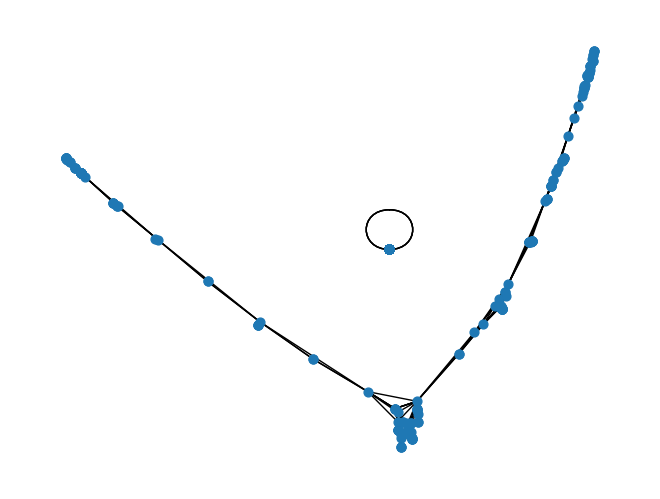

In [17]:
nx.draw(G, pos, node_size=40)